# Neural Style Transfer wih PyTorch 

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image

from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import math
from PIL import Image
import glob
from IPython.display import display

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


HYPERPARAMETERS

In [3]:
IMG_SIZE = 512
NUM_EPOCHES = 5000
LR = 1e-4
ALPHA = 0.5
BETA = 0.5

## Preprocess

In [4]:
toTensor = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

toPIL = transforms.Compose([
    transforms.ToPILImage()
])

In [5]:
def get_image(path, device):
    image = Image.open(path)
    image = toTensor(image).unsqueeze(0)
    return image.to(device)

In [6]:
content = get_image("input/content1.jpeg", device)
style = get_image("input/style1.jpeg", device)

## Model

In [7]:
class VGG_model(nn.Module):
    def __init__(self):
        super(VGG_model, self).__init__()
        self.model_layers = models.vgg.vgg19(pretrained=True).features
        self.content_layers = ["0", "5", "10", "28"]
        
        for parameter in self.model_layers.parameters():
            parameter.requires_grad = False
        
    def forward(self, image):
        batch_size = image.size(0)
        output = image
        output_layers = []
        for name, module in self.model_layers.named_children():
            output = module(output)
            if name in self.content_layers:
                output_layers.append(output)
        return output_layers
    
    def feature_perceptual_loss(self, recon_x, x):
        total_loss = 0
        for x1, x2 in zip(recon_x, x):
            total_loss += F.mse_loss(x1, x2)
        return total_loss
    
    def style_loss(self, generated_image, content_images, style_images, alpha=0.5, beta=0.5):
        
        Style_Loss = 0
        Content_Loss = 0
        
        for x, y, z in zip(generated_image, content_images, style_images):
            b, c, w, h = x.shape
            gm1 = x.view(c, w*h).mm(x.view(c, w*h).t())
            gm2 = z.view(c, w*h).mm(z.view(c, w*h).t())
            Content_Loss += torch.mean((x - y)**2)
            Style_Loss += torch.mean((gm1 - gm2)**2)
        
        return ((alpha * Content_Loss) + (beta * Style_Loss))

Model Parameters

In [8]:
model = VGG_model()
model.to(device).eval()

VGG_model(
  (model_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [9]:
next(model.parameters()).is_cuda # returns a boolean

True

## Train

In [10]:
generate = content.clone().requires_grad_(True).to(device)

In [11]:
optimizer = torch.optim.Adam([generate], lr = LR)

In [12]:
start_time = time.time()

for epoch in range(1, NUM_EPOCHES+1):
    loss = 0
    
    generated = model(generate)
    styled = model(style)
    contented = model(content)
    
    loss = Style_Loss = model.style_loss(generated, contented, styled, alpha=ALPHA, beta=BETA)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%500==0:
        print("_______________________________________________________")
        print("Epoch Num: {}".format(epoch))
        print("Loss: {}".format(loss))
        print("_______________________________________________________")
    
end_time = time.time()
print("Time Elapsed for Style Transfer: {}".format(end_time - start_time))

_______________________________________________________
Epoch Num: 100
Loss: 15417507.0
_______________________________________________________
_______________________________________________________
Epoch Num: 200
Loss: 10985393.0
_______________________________________________________
_______________________________________________________
Epoch Num: 300
Loss: 9664876.0
_______________________________________________________
_______________________________________________________
Epoch Num: 400
Loss: 8866115.0
_______________________________________________________
_______________________________________________________
Epoch Num: 500
Loss: 8244795.5
_______________________________________________________
_______________________________________________________
Epoch Num: 600
Loss: 7722681.0
_______________________________________________________
_______________________________________________________
Epoch Num: 700
Loss: 7267863.0
_____________________________________________________

In [13]:
save_image(generate, "output/generate1.png")

## Visualize

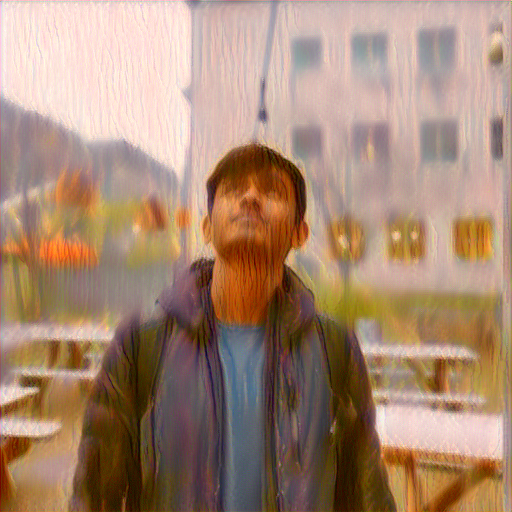

In [14]:
display(Image.open("output/generate1.png"))